# Coursework 2 – Machine Learning  
## Image Classification
**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** Machine Learning   
**Updated:** 27th November 2025  

## Project Overview
The goal of this project is to develop a supervised learning model capable of accurately classifying images into multiple categories. The Intel Image Classification Dataset is used, which contains labeled images of various classes.  

## Importing Libraries
We will use the following libraries for this task:

- **TensorFlow/Keras**: Build and train the neural network.
- **NumPy**: Array manipulation and numerical operations.
- **Matplotlib**: Visualize accuracy, loss, and results.
- **kagglehub**: Download dataset from Kaggle.

If any library is missing, it can be installed using pip.

In [1]:
""" pip command to install above packages for our ML model to run.
Please note TensorFlow will take around 650MB of Storage space. 
Make sure you have sufficient storage before running this notebook
Remove -q argument to see the install progress """

""" If you have Python 3.11 and Intel machine, 
intel extension for tensorflow can be installed that may increase training process in windows machines with intel CPU and iGPUs
Only with Python 3.11 or later

pip install tensorflow==2.12
pip install intel-extension-for-tensorflow[cpu]==1.2.0

"""

!pip install tensorflow numpy matplotlib kagglehub scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/8.7 MB 11.8 MB/s eta 0:00:01
   --------------------- ------------------ 4.7/8.7 MB 11.8 MB/s eta 0:00:01
   -------------------------------- ------- 7.1/8.7 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 11.5 MB/s  0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/38.5 MB 11.8 MB/s eta 0:00:04
   ---- ----------------------------------- 4.7/38.5 MB 11.8 MB/s eta 0:00:03
   ------- -------------------------------- 7.3/38.5 MB 11.8 MB/s eta 0:00:03
   ---------- ----------------------------- 9.7/38.5 MB 11.8 MB/s eta 0:00:03
   ------------ --------------------------- 12.1/38.5 MB 11.8 MB/s eta 0:00:03
   --------------- ------------------------ 14.7/38.5 MB 11.8 MB/s eta 0:00:03
   ----------------- ---------------------- 17.0/38.5 MB 11.8 MB/s eta 0:00:02
   ----

In [2]:
# Import Required Libraries
import os
import shutil

# To download dataset if it does not exist
import kagglehub

# NumPy for numerical and array manipulation
import numpy as np

# Matplotlib for plotting and seaborn for graphs
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow and Keras for building and training the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory


## Loading and Organising Dataset
We use the Intel Image Classification dataset. Kagglehub downloads the dataset to a default cache directory, so we move it to a working directory called `intel-data`.  

In [3]:
# Get currect working directory
current_dir = os.getcwd()

# Define target directory to copy dataset
target_dir = os.path.join(current_dir, "intel-data")

if os.path.exists(target_dir):
    print("Directory already exists. Please Continue below or delete intel-data directory to download data again")
    pass
else:
    
    # Download Intel Image Classification Dataset and capture its path in below variable
    path = kagglehub.dataset_download("puneet6060/intel-image-classification")
    print("Download Path: ", path)

    # Move from cache to target directory
    shutil.move(path, target_dir)
    print("Moved to: ", target_dir)

Directory already exists. Please Continue below or delete intel-data directory to download data again


## Prepare Training and Validation Sets
The `image_dataset_from_directory` utility automatically reads images from folders, assigns labels based on subfolder names, and prepares batches for training.  

- **Training set**: 80% of images used to train the model.
- **Validation set**: 20% of training images used to evaluate model performance during training.
- **Batch size**: 16 images per batch. Can be increase when training for production
- **Image size**: Original stock image sizes are 150x150, with 3 color channels (RGB). We will be downscaling to speedup model training

In [4]:
# Assign global tensorflow seed to change randomness to predictable random number
#tf.random.set_seed(10)
#np.random.seed(10)
#tf.keras.utils.set_random_seed(10)

# Assign corresponding directories to variables.
train_dir = os.path.join(target_dir, "seg_train/seg_train")
val_dir = os.path.join(target_dir, "seg_test/seg_test")

train_data = image_dataset_from_directory(
    train_dir,
    image_size=(128,128), # Downscaled
    batch_size=32, # Small batch size to speed up training to test. Increase it to 32 or 64 when training for production
    label_mode='categorical'
)

val_data = image_dataset_from_directory(
    val_dir,
    image_size=(128,128), # Downscaled
    batch_size=32, # Small batch size to speed up training to test. Increase it to 32 or 64 when training for production
    label_mode='categorical',
    shuffle=False
)

num_classes = len(train_data.class_names)

# Data Loading Pipeline for faster data fetching
train = train_data.cache().prefetch(tf.data.AUTOTUNE)
validation = val_data.cache().prefetch(tf.data.AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [5]:
# Check your data distribution
print("Training class distribution:")
for i, class_name in enumerate(train_data.class_names):
    count = sum(1 for _, labels in train_data.unbatch() if tf.argmax(labels) == i)
    print(f"{class_name}: {count} samples")

print("\nValidation class distribution:")
for i, class_name in enumerate(train_data.class_names):
    count = sum(1 for _, labels in val_data.unbatch() if tf.argmax(labels) == i)
    print(f"{class_name}: {count} samples")

Training class distribution:
buildings: 2191 samples
forest: 2271 samples
glacier: 2404 samples
mountain: 2512 samples
sea: 2274 samples
street: 2382 samples

Validation class distribution:
buildings: 437 samples
forest: 474 samples
glacier: 553 samples
mountain: 525 samples
sea: 510 samples
street: 501 samples


## Convolutional Neural Network (CNN) Architecture
The CNN consists of:

1. **Input Layer**: Accept Downscaled labels
2. **Conv2D + MaxPooling Layers**: Extract features from images.
3. **Flatten Layer**: Converts 2D feature maps into a 1D vector.
4. **Dense Layer**: Fully connected layer with specified number of neurons.
5. **Dropout Layer**: To prevent overfitting. Enable it when using large number of neurons
6. **Output Layer**: Specify number of classes, with softmax activation for multi-class classification.

This model is suitable for extracting patterns from images and making predictions.

In [6]:
# Randomize image to improve generalization. 
# Use it when training with large batches and epochs for it to be effective
# Please note that augmentation affected by global seed set above.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Sequential Model is used 
model = Sequential([
    # Specifies downscaled input 128x128, 3 channels. Means 3 channel colors RGB
    Input(shape=(128,128,3)),

    # Wrap Data augmentation in model input.
    # Please uncomment below to enable augmentation and only enable it when training full dataset and on large epochs
    # data_augmentation,

    # First convolution block, uses activation Rectified Linear Unit. Applies 32 filters, 3x3 pixel
    Conv2D(32, (3,3), activation='relu'),
    # Get Stronges pixels 2x2
    MaxPooling2D(2,2),
    
    # Second Convolution block with 64 filters applied
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # 3rd convolution block with 128 filters applied
    Conv2D(86, (3,3), activation='relu'),
    GlobalAveragePooling2D(),

    # Fully connected Layer with neurons. Decision making layer. Increase number of neurons when on large epochs
    Dense(128, activation='relu'),

    # Disables given amount of neurons to prevent model overfitting
    # Uncomment below when on large neurons to drop
    Dropout(0.2),

    # Output layer. gives prediction using softmax to 6 classes (num_classes) defined above
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 86)          │          49,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 86)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          11,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,924 (316.11 KB)

 Trainable params: 80,924 (316.11 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model
- **Optimizer**: Adam optimizer for efficient gradient descent.
- **Loss function**: Categorical crossentropy for multi-class classification.
- **Metrics**: Accuracy to monitor model performance.

We train the model for 8 epochs with the training and validation datasets.

In [7]:
# Only for testing purposes. Please Comment below lines when training on full dataset
#small_train = train.take(80)
#small_val = validation.take(10)

# Compile model. Uses adam optimizer and tries to minimize loss categorical_crossentropy
model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)

# When training on full dataset replace small_train with train and 
# small_val with validation to feed model with full dataset split
history = model.fit(
train,
validation_data=validation,
epochs=5
)

Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.5038 - loss: 1.3807 - val_accuracy: 0.5907 - val_loss: 0.9503
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.6754 - loss: 0.8420 - val_accuracy: 0.6837 - val_loss: 0.7990
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 121ms/step - accuracy: 0.7450 - loss: 0.6969 - val_accuracy: 0.7760 - val_loss: 0.6237
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 121ms/step - accuracy: 0.7799 - loss: 0.6157 - val_accuracy: 0.7860 - val_loss: 0.5848
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 121ms/step - accuracy: 0.7955 - loss: 0.5737 - val_accuracy: 0.8067 - val_loss: 0.5411


## Model Evaluation
We evaluate the model using:

**Accuracy and Loss Plots**: Shows training vs validation performance over epochs.

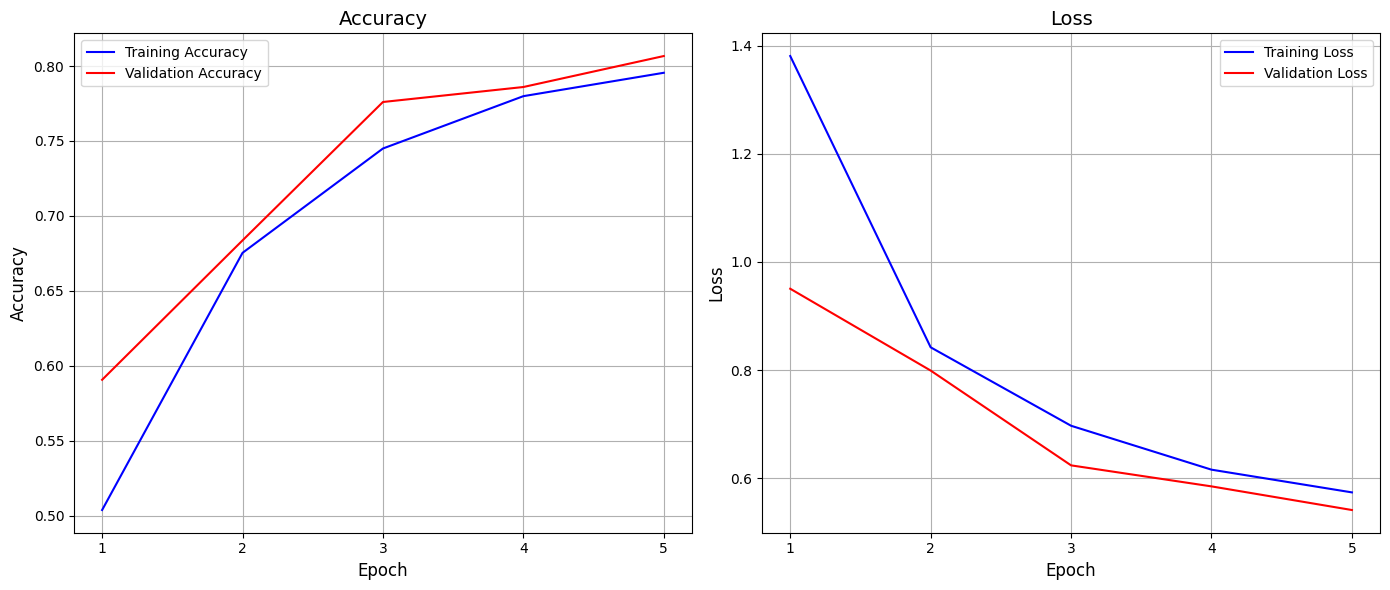

In [8]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

# Create Plot
plt.figure(figsize=(14,6))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Confusion Matrix**: Illustrates correct vs incorrect predictions for each class.

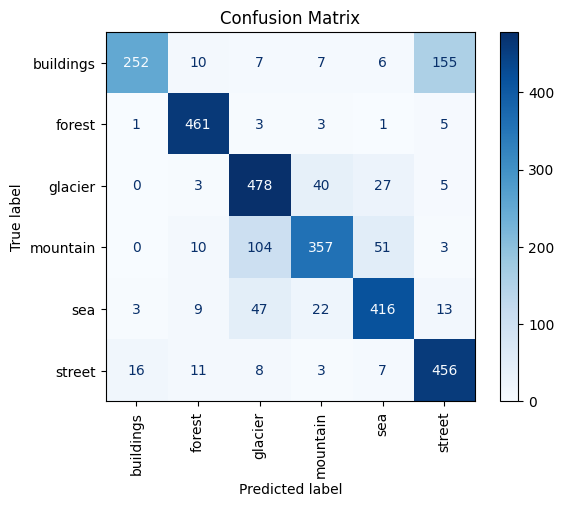

In [12]:
y_true_list = []
y_pred_list = []

for x_batch, y_batch in val_data:  # val_data = seg_test dataset
    y_pred_batch = tf.argmax(model(x_batch, training=False), axis=1)
    y_true_batch = tf.argmax(y_batch, axis=1)
    
    y_pred_list.append(y_pred_batch)
    y_true_list.append(y_true_batch)

# Concatenate all batches
y_true = tf.concat(y_true_list, axis=0)
y_pred = tf.concat(y_pred_list, axis=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Load test dataset
test_dir = os.path.join(target_dir, "seg_test/seg_test")
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8037 - loss: 0.5625
Test Accuracy: 80.37%
